In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import multiprocessing as mp
import numpy as np
import scipy.sparse.linalg as splin
import random
import math
import heapq
from os.path import isfile
from sklearn.externals.six import StringIO
import pydotplus
import igraph as ig
import time
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from collections import *
import cPickle as pkl
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from scipy.sparse import dok_matrix

In [2]:
import pymongo
# Database nonsense
# Intitalize the collection 
def set_up_collection(name):
    """
    Set up a collection of edges for a named graph
    This will ensure that the fields edge, source and target exists, that edges are unique and there's an index on source
    """
    client = pymongo.MongoClient()
    db = client[name]
    db['edges'].create_index('edge', unique=True)
    db['edges'].create_index('source')
    return db['edges']

def get_precalculated(candidate_edges, field):
    # Find all edges that have the requested field and exists in candidate_edges. 
    # NB: mongodb doesn't know tuples, so edge is a string
    results = []
    max_requests = 200000
    n = len(candidate_edges) / max_requests
    for i in xrange(n):
        results += list(edge_col.find({'edge': 
                                       {'$in': [str((x,y)) for x,y,_ in candidate_edges[i*max_requests:(i+1)*max_requests]]}, 
                                        field: {'$exists': True}}, 
                                        {'source': True, 'target': True, field: True}))
    results += list(edge_col.find({'edge': 
                                   {'$in': [str((x,y)) for x,y,_ in candidate_edges[(i+1)*max_requests:]]}, 
                                    field: {'$exists': True}}, 
                                    {'source': True, 'target': True, field: True}))

    print "Already calculated: {}".format(len(results))
    # Present the data as expected by feature extractors
    results = [(record['source'], record['target'], {'score': record[field]}) for record in results]
    # Filter out known edges from the candidate set
    known_edges = set([(record[0], record[1]) for record in results])
    candidate_edges = [edge for edge in candidate_edges if not (edge[0], edge[1]) in known_edges]
    # Return the current results, the unknown edges and the known edges to save time when saving
    # NB: known_edges can be omitted although it will make for many more inserts later on
    return results, candidate_edges, known_edges


def save_precalculated(records, field, pre_calculated):
    
    pre_calculated = set(pre_calculated)
    records = {(x,y):{field: data['score']} for x,y,data in records}
    to_be_updated = []
    update_filter = list(set(records.keys()) - pre_calculated)
    # To avoid the BSON filesize limit of 16 MB per document it is necessary to spread out the queries
    max_requests = 200000
    n = len(update_filter) / max_requests
    for i in xrange(n):
        to_be_updated +=  list(edge_col.find({'edge': 
                                              {'$in': [str(edge) for edge in update_filter[i*max_requests:(i+1)*max_requests]]}, 
                                              field: {'$exists': False}}))
    
    to_be_updated += list(edge_col.find({'edge': 
                                          {'$in': [str(edge) for edge in update_filter[(i+1)*max_requests:]]}, 
                                          field: {'$exists': False}}))
    to_be_deleted = []
    for existing_record in to_be_updated:
        # Unicode returned from mongo needs to be converted to str the tuple will render wrong when converted to string...sorry
        edge = (str(existing_record['source']), str(existing_record['target']))
        to_be_deleted.append(str(edge))
        records[edge].update(existing_record)
    print "To be updated: {}".format(len(to_be_deleted))
    # Remove all edges that need to be updated
    res = edge_col.delete_many({'edge': {'$in': to_be_deleted}})
    print "Deleted: {}:".format( res.deleted_count)
    to_be_saved = []
    for edge, data in records.iteritems():
        if not edge in pre_calculated:
            data.update({'edge' : str(edge), 'source': edge[0], 'target': edge[1]})
            to_be_saved.append(data)
    print "To be saved: {}".format(len(to_be_saved))
    if len(to_be_saved) > 0:
        edge_col.insert_many(to_be_saved)

edge_col = set_up_collection('euchr_test1')

In [3]:
%run load_data.py
GRAPH = 'EUCHR'
np.random.seed(42)
random.seed(42)


# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())

In [137]:
def successors_scoped(node, head, G):
    """
    Return the successors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return successors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G[node] if G.node[n]['date'] <= max_time]

def predecessors_scoped(node, head, G):
    """
    Return the predecessors of a node scoped to the time specified by the head node
    
    arguments:
    node -- node to return predecessors for
    head -- node containing the timestamp to scope the graph to
    G -- graph containing the nodes
    """
    max_time = G.node[head]['date']
    return [n for n in G.pred[node] if G.node[n]['date'] <= max_time]

def scoped_neighborhood(node, head_node, G):
    """
    Return the neighborhood of a node at a given timestamp
    
    arguments:
    node -- node to find the neighborhood for
    head_node -- node containing the timestamp to filter the nodes by
    G -- directed graph containing the node
    """
    max_date = G.node[head_node]['date']
    pre = predecessors_scoped(node, head_node, G)
    suc = successors_scoped(node, head_node, G)
    return list(set(pre).union(set(suc)))    
    
def scoped_out_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_in_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamp
    
    arguments:
    node -- node to return the degree for
    head_node -- node containing the timestamp to filter the nodes by
    G -- graph containing the nodes
    """
    max_date = G.node[head_node]['date']
    neighborhood = [n for n in G.pred[node] if G.node[n]['date'] <= max_date]
    return len(neighborhood)

def scoped_degree(node, head_node, G):
    """
    Return the degree of a node at a given timestamop
    """
    return len(scoped_neighborhood(node, head_node, G))

def get_common_neighbors(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.intersection(v)

def get_neighbor_union(x,y,G):
    u = set(scoped_neighborhood(x,x,G))
    v = set(scoped_neighborhood(y,x,G))
    return u.union(v)

def get_common_referrers(x,y,G):
    common_referrers_source = {n for m in successors_scoped(x, x, G) for n in predecessors_scoped(m, x, G)} - {x}
    referrers_to_target = set(predecessors_scoped(y,x,G))
    return common_referrers_source.intersection(referrers_to_target)

    
def common_referrers(validation_set, G, weighting_scheme=None):
    """
    For a given node pair x and y, return the number of nodes that both refer to a node that x also refers and refers to y
    or f(y) intersection g(f(x)) where f returns the predeccessors of a node and g returns the successors
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
 
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        cn = get_common_referrers(x,y,G)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, G) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def common_neighbors(validation_set, G, weighting_scheme=None, recalculate=False):
    """
    Perform common neighbors scoring on a list of edges, backed by the database
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    recalculate -- Whether to load edges from the database or recalculate them all    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,GCC)
        if weighting_scheme and weighting_scheme.is_local():
            weights = []
            for z in cn:
                weights.append(weighting_scheme.score(z, x, GCC) * 1.0)
            s = sum(weights)
        else:
            s = len(cn)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x,y,GCC)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

class WeightingScheme():
    
    def is_global(self):
        return self.weight_type == "global"
    def is_local(self):
        return self.weight_type == "local"
        

class Jaccard(WeightingScheme):
    
    def __init__(self):
        self.weight_type = "global"
    
    def score(self,x,y,G):
        """
        Perform jaccard scoring on a list of edges

        arguments:
        validation_set -- list of edges to score
        G -- digraph containing the nodes in the edges of the validation set

        returns:
        list of edges with score as an attribute
        """
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        try:
            s = 1.0*len(u & v)/len(u | v)
        except:
            s = 0.0
        return s
    
class AdamicAdar(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the AdamicAdar coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/math.log(scoped_degree(z, x, G))
        else:
            return 0.0

        
class ResourceAllocation(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'local'
        
    def score(self, z, x, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        deg = scoped_degree(z,x,G)
        if deg > 1:
            return 1.0/scoped_degree(z, x, G)
        else:
            return 0.0


        
class LeichtHolmeNewman(WeightingScheme):
    
    def __init__(self):
        self.weight_type = 'global'
        
    def score(self, x, y, G):
        """
        Return the RA coefficient for a single neighbor z, scoped to the time of a node x
        
        arguments:
        z -- node to return the AA coefficient for
        x -- node that holds the timestamp to scope z to
        G -- graph containing x and z
        """
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg > 0 and y_deg > 0:
            return 1.0/x_deg*y_deg
        else:
            return 0.0

class HubDepressed(WeightingScheme):
    def __init__(self):
        self.weight_type = 'local'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/min(x_deg, y_deg)
        else:
            return 0.0
    
class HubPromoted(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'

    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 or y_deg != 0:
            return 1.0/max(x_deg, y_deg)
        else:
            return 0.0

class Salton(WeightingScheme):
    def __init__(self):
        self.weight_type = 'global'


    def score(self, x, y, G):
        x_deg = scoped_degree(x,x,G)
        y_deg = scoped_degree(y,x,G)
        if x_deg != 0 and y_deg != 0:
            return 1.0/math.sqrt(x_deg*y_deg)
        else:
            return 0.0

def hub_depressed(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 and scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/min(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def hub_promoted(validation_set, G):
    """
    Find the hub promoted similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) != 0 or scoped_in_degree(y, x, G) != 0:
            s = 1.0*len(cn)/max(scoped_out_degree(x, x, G),scoped_in_degree(y, x, G))
        else:
            s = 0.0
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def salton(validation_set, G):
    """
    Find the salton similarity of a single edge
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/math.sqrt(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def leicht_holme_newman(validation_set, G):
    """
    Perform LHN1 scoring on a single edge
    
    arguments:
    non_edge -- edge tuple specified by node endpoints
    G -- graph containing the nodes in the edge
    
    return:
    edges with the score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        cn = get_common_neighbors(x,y,G)
        if scoped_out_degree(x, x, G) == 0 or scoped_in_degree(y, x, G) == 0:
            s = 0.0
        else:
            s = 1.0*len(cn)/(scoped_out_degree(x, x, G)*scoped_in_degree(y, x, G))
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def adamic_adar(validation_set, G):
    """
    Perform jaccard scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = -1*sum([1.0/math.log(scoped_degree(node, x, G)) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def resource_allocation(validation_set, G):
    """
    Perform resource allocation scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """
    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        neighbors = get_common_neighbors(x,y,G)
        s = sum([1.0/scoped_degree(node, x, G) for node in neighbors if scoped_degree(node, x, G) > 1])
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results


def preferential_attachment(validation_set, G):
    """
    Perform preferential attachment scoring on a list of edges
    
    arguments:
    validation_set -- list of edges to score
    G -- digraph containing the nodes in the edges of the validation set
    
    returns:
    list of edges with score as an attribute
    """

    results = []
    for non_edge in validation_set:
        x = non_edge[0]
        y = non_edge[1]
        s = scoped_out_degree(x,x,G)*scoped_in_degree(y,x,G)
        non_edge[2]['score'] = s
        results.append(non_edge)
    return results

def triadic_closeness(validation_set, G, census=None, weighting_scheme=None):
    
    results = []
    if census == None:
        census = triadic_distribution(G)
    for non_edge in validation_set:
        
        x = non_edge[0]
        y = non_edge[1]
        connected = y in G[x]
        if connected:
            G.remove_edge(x,y)
        u = set(scoped_neighborhood(x,x,G))
        v = set(scoped_neighborhood(y,x,G))
        cn = u.intersection(v)
        t_score = []
        for z in cn:
            triad = get_triad(x,z,y,G)
            if census[triad] == 0:
                continue
            try:
                F2 = census[triad+30]
            except KeyError:
                F2 = 0.0
            try:
                F1 = census[triad+10]
            except KeyError:
                F1 = 0.0
            
            # Add in any weighting schemes that work on the individual nodes in the common neighborhood
            if weighting_scheme and weighting_scheme.is_local():
                score = weighting_scheme.score(z, x, GCC)*(1.0*F1 + F2)/census[triad]
            else:
                score = (1.0*F1 + F2)/census[triad]
            
            t_score.append(score)
        s = sum(t_score)
        if weighting_scheme and weighting_scheme.is_global():
            s = s*weighting_scheme.score(x, y, G)
        if len(non_edge) > 2:
            non_edge[2]['score'] = s
            results.append(non_edge)
        else:
            results.append(s)
        if connected:
            G.add_edge(x,y)
    return results

def triadic_distribution(G):
    """
    Return the distribution of closed triad configurations for a graph
    The distribution is labelled as in the paper by Schall
    http://link.springer.com.proxy.findit.dtu.dk/article/10.1007/s13278-014-0157-9
    
    arguments:
    G -- directed graph
    
    returns:
    Dict of labels with counts
    """
    
    # Integer labels as presented in the paper
    TRIAD_NAMES = range(1,10) + range(11, 20) + range(21,30) + range (31, 40)
    census = {name: 0 for name in TRIAD_NAMES}
    for u in G.nodes_iter():
        u_neighbors = list(set(G.successors(u)) | set(G.predecessors(u)))
        for z in u_neighbors:
            z_neighbors = list((set(G.successors(z)) | set(G.predecessors(z))) - {u} )
            for v in z_neighbors:
                name = get_triad(u,z,v, G)
                census[name] += 1
    return census


def get_triad(u,z,v,G):
    """
    Return the triad created by the nodes u,v and z
    This implementation is quite probably awful.
    
    parameters:
    
    u -- starting node
    z -- connecting node
    v -- ending node
    G -- DiGraph containing the nodes
    
    returns:
    Dict containing closed triad counts
    """
    
    u_out = G[u]
    v_out = G[v]
    z_out = G[z]
    id = 0
    
    if v in u_out and u in v_out:
        id = 30
    elif u in v_out:
        id = 20
    elif v in u_out:
        id = 10
    
    if u in z_out and z not in u_out:
        id += 7
        if v in z_out and z not in v_out:
            return id + 2
        elif z in v_out and v not in z_out:
            return id + 1
        elif z in v_out and v in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in v_out and v not in z_out:
        id += 5
        if z in u_out and u not in z_out:
            return id + 1
        elif z in u_out and u in z_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u not in z_out:
        id += 3
        if v in z_out and z not in v_out:
            return id + 1
        if v in z_out and z in v_out:
            return id
        raise Exception("Error in finding triad")
    elif z in u_out and u in z_out:
        if v in z_out and z not in v_out:
            return id + 2
        elif v in z_out and z in v_out:
            return id + 1
    
    raise Exception("No triad found")
        

def get_closed_triads(x, y, G):
    """
    Return the closed triads generated by adding a link from x to y.
    Triads are classified according to the triadic_census algorithm of NetworkX based on 
    http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf
    """
    
    # Taken directly from nx.triadic_census source
    TRIAD_NAMES = ('003', '012', '102', '021D', '021U', '021C', '111D', '111U',
                   '030T', '030C', '201', '120D', '120U', '120C', '210', '300')
    census = {name: 0 for name in TRIAD_NAMES}
    
    x_in = set(G.predecessors(x))
    y_in = set(G.predecessors(y))
    x_out = set(G.successors(x))
    y_out = set(G.successors(y))
    
    for node in x_in | y_in | x_out | y_out:
        # y refers to a node that refers to x
        if node in x_in and node in y_out:
            census['030C'] += 1
        # y is being referred to by a node that refers to x
        if node in x_in and node in y_in:
            census['030T'] += 1
        # x refers to a node that refers to y
        if node in x_out and node in y_in:
            census['030T'] += 1
        # x refers to a node that y refers to
        if node in x_out and node in y_out:
            census['030T'] += 1

def time_difference(candidate_edges, G):
    """
    Return the time difference for a set of edges
    """

    results = []
    
    results = [(x,y, {'score': int((G.node[x]['date'] - G.node[y]['date']).days)}) for x,y,_ in candidate_edges]
    return results

def shortest_dag_path(candidate_edges, G):
    results = []
    longest_possible_path = len(G.nodes())
    for x,y,_ in candidate_edges:
        connected = y in G[x].keys()
        if connected:
            G.remove_edge(x,y)
        try:
            results.append((x,y,{'score': nx.shortest_path_length(G,x,y)}))
        except:
            results.append((x,y, {'score': longest_possible_path}))
        if connected:
            G.add_edge(x,y)
    return results
        
class CommonNeighbors():
    """
    An experiment that scores a list of edges based on the number of common neighbors between the source and the target node
    """
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
        
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common neighbors index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        false_validation_edges = [(source, target) for source in source_nodes
                   for neighbor in G[source].keys()
                   for target in set(scoped_neighborhood(neighbor, source, G)) - {source} if target not in G[source].keys()]
        
        false_validation_edges = list(set(false_validation_edges))
        for i in range(len(false_validation_edges)):
            edge = false_validation_edges[i]
            # Add date information to the non-edge
            false_validation_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return false_validation_edges
        
    def score_edges(self, edges, G):
        return common_neighbors(edges, G, self.weighting_scheme)
    
class TriadicCloseness(CommonNeighbors):
    
    def __init__(self, cache_distribution=False, weighting_scheme=None):
        self.cache_distribution = cache_distribution
        self.census = None
        self.weighting_scheme=weighting_scheme
    
    def score_edges(self, edges, G):
        
        if self.cache_distribution == True and self.census == None:
            self.census = triadic_distribution(G)
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
        else:
            return triadic_closeness(edges, G, self.census, self.weighting_scheme)
    
class CommonReferrers():
    
    def __init__(self, weighting_scheme=None):
        self.weighting_scheme = weighting_scheme
    
    def valid_false_edges(self, G, source_nodes):
        """
        Returns a list of edges that do not exist in G and will score highly on the common referrers index
        
        Parameters
        ----------
        G: networkX.Graph
            Graph to perform experiment on
        source_nodes: list of tuples
            Nodes containing the true edges to be scored
        """
        non_edges = []
        for source in source_nodes:
            neighbors = G[source].keys()
            corefs = set()
            for neighbor in neighbors:
                corefs = corefs | {c for c in predecessors_scoped(neighbor, source, G)}
            [non_edges.append((source, referee)) for coref in (corefs - {source}) 
                                                 for referee in set(successors_scoped(coref, source, G)) - set(neighbors)]
            
        for i in range(len(non_edges)):
            edge = non_edges[i]
            # Add date information to the non-edge
            non_edges[i] = edge + ({'date': G.node[edge[0]]['date']},)
        
        return non_edges
    
    def score_edges(self, edges, G):
        return common_referrers(edges, G, self.weighting_scheme)
            
                
def valid_random_non_edges(graph, n):
    """
    Returns randomized, non-existent links between nodes in the graph that are guaranteed to observe causality.

    Parameters
    ----------
    graph : NetworkX graph.
        Graph to find non-existent edges.
    n : integer
        Number of non-existent edges to find

    Returns
    -------
    non_edges : list
        List of n edges that are not in the graph.
    """
    result_pairs = {}
    # Sort edges according to age
    sorted_edges =[node for node, data in sorted(graph.nodes(data=True), key=lambda x: x[1]['date'], reverse=True)]
    node_set = set(graph.nodes())
    candidates = list(np.random.choice(sorted_edges, n, replace=True))
    i = 0
    while i < len(candidates):
        u = candidates[i]
        if not u in result_pairs.keys():
            result_pairs[u] = []
            
        # Make sure the potential neighbors respect causality with a resolution equal to the timestamp
        cand_index = sorted_edges.index(u)
        potential_neighbors = set(sorted_edges[cand_index:])
        if graph.is_directed():
            neighbors = set(graph.successors(u)).union(set(graph.predecessors(u)))
        else:
            neighbors = set(graph.neighbors(u))
        # Make sure the potential neighbors respect causality
        non_neighbors = list(potential_neighbors - neighbors - set(result_pairs[u]))
        # The oldest node will have a neighborhood of Ø, so add a new candidate to the list in that case
        if len(non_neighbors) == 0:
            candidates.append(random.choice(graph.nodes()))
        else:    
            result_pairs[u].append(random.choice(non_neighbors))
        i += 1
    
    return [(k,v) for k, arr in result_pairs.iteritems() for v in arr]
        

def k_fold_validate(G, k, experiment):
    """
    K-fold validation of some specified function
    
    arguments:
    G -- Graph to perform the function on
    k -- number of folds
    fun -- function to be evaluated
    kwargs -- arguments to be passed to the evaluated function
    
    return:
    List of lists of scored predictions
    """
    results = []
    validation_sets = []
    edges = G.edges(data=True)
    random.shuffle(edges)
    # Find all edges that do not exist in the graph, but will return a high score
    false_edges = experiment.valid_false_edges(G, G.nodes())
    random.shuffle(false_edges)
    M = len(false_edges)/k
    # Find the number of true members in the validation set
    N = len(edges)/k
    for i in range(0,k):
        validation_sets.append(edges[i*N:(i+1)*N] + false_edges[i*M:(i+1)*M])
    for val_edges in validation_sets:
        res = experiment.score_edges(val_edges, G)
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(res)
        results.append(res)
    return results

def k_fold_nodes(G, k, experiment):
    """
    Perform k-fold validation on the nodes of the graph.
    This validation only tests relevant false edges, i.e. edges where we are fairly certain the score won't come out as 0.0
    making it useful for precision / recall, but not for AUC. The true edges can still score 0.0
    """
    results = []
    nodes = G.nodes()
    random.shuffle(nodes)
    N = len(nodes)/k
    validation_sets = []
    for i in range(0, k):
        validation_sets.append(nodes[i*N:(i+1)*N])
    for true_nodes in validation_sets:
        # Validation sets consist of all possible the edges in 
        val_edges = [(source, target, G[source][target]) for source in true_nodes for target in G[source].keys()]
        val_set = set((source, target) for (source, target, _) in val_edges)
        G_train = G.copy()
        G_train.remove_edges_from(val_edges)
        false_validation_edges = experiment.valid_false_edges(G, true_nodes)
        false_validation_edges = [(x,y,data) for (x,y,data) in false_validation_edges if (x,y) not in val_set]
        validation_set = val_edges + false_validation_edges
        # If not shuffled, subsequent sorting algorithms will always rank true edges higher than false edges when they have
        # the same score
        random.shuffle(validation_set)        
        results.append(experiment.score_edges(validation_set, G))
    return results

def at_degree_validation(G, experiment, degree):
    if degree < 2:
        raise Exception('Degree must be larger than 2')
    res = {}
    H = G.copy()
    to_be_evaluated = []
    # Randomly sample n nodes from each degree bin
    deg=nx.degree(G)
    h = {}
    for node in G.nodes_iter():
        if G.out_degree(node) == degree:
            to_be_evaluated.append(node)
    for node in to_be_evaluated:
        res[node] = []
        e = G.edges(node, data=True)
        if not len(e) == degree:
            raise Exception("Mismatch: {}".format(len(e)))
        G.remove_edges_from(e[1:degree-1])
        for i in range(1, degree):
            to_be_scored = experiment.valid_false_edges(H, [node]) + e[i:degree]
            random.shuffle(to_be_scored)
            scored_edges = experiment.score_edges(to_be_scored, G)
            [edge[2].update({'n_edges': i}) for edge in scored_edges]
            res[node] += scored_edges
            #res[node][i] = scored_edges
            G.add_edge(e[i][0], e[i][1])
    return res
        
def precision(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    results = [sorted(result, key=lambda x: x[2]['score'], reverse=True) for result in results]
    for res in results:
        if L > len(res):
            raise ArgumentError("L is larger than the number of results")
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [[(edge[0],edge[1]) for edge in result[0:L] if (edge[0], edge[1]) in edge_set] for result in results]
    return [1.0*len(trues)/L for trues in true_positives]

def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions
    

def precision2(G, results, L):
    """
    Find the ratio of the true positives to trues
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    L -- number of results to be considered
    
    return:
    List of precisions for each set of results
    """
    # Sort the results with descending scores
    #results = heapq.nlargest(L, results, key=lambda x: x[2]['score'])
    edge_set = set(G.edges())
    # True positives exist in both the edge set and the result set
    true_positives = [(edge[0],edge[1]) for edge in results if (edge[0], edge[1]) in edge_set]
    return 1.0*len(true_positives)/L

def AUC(G, results):
    """
    Perform n trials where the score of a non-edge and an edge in the result is compared. Count the number of trials where
    the edge had the higher score as n' and the number of times the score was equal as n'' and return the AUC as (n' + n'')/n.
    
    arguments:
    G -- graph the results are based on
    results -- list of lists of scored predictions
    
    return:
    List of precisions for each set of results
    """
    
    edge_set = set(G.edges())
    AUC = []
    for result_set in results:
        true_edges = []
        false_edges = []
        for (x,y,data) in result_set:
            if (x,y) in edge_set:
                true_edges.append((x,y,data))
            else:
                false_edges.append((x,y,data))
        
        random.shuffle(true_edges)
        random.shuffle(false_edges)
        n = len(true_edges)
        n_better = 0.0
        n_same = 0.0
        for i in range(0, n):
            if true_edges[i][2]['score'] > false_edges[i][2]['score']:
                n_better += 1.0
            if true_edges[i][2]['score'] == false_edges[i][2]['score']:
                n_same += 1.0
        AUC.append((n_better + 0.5*n_same)/n)
    return AUC

def slice_graph_by_year(start_year, end_year, G):
    """
    Returns all nodes created within a range of years
    """
    if datetime.date(start_year, 1, 1) < datetime.date(end_year, 1, 1):
        raise ArgumentError("The starting year must be larger than or equal to the ending year")
    t1 = datetime.date(start_year, 12, 31)
    t2 = datetime.date(end_year, 1, 1)
    
    return [n for n in G.nodes(data=True) if n[1]['date'] >= t2 and n[1]['date'] < t1]

f = lambda x, y, G: y in G[x].keys()
features = ['edge',
            'triadic_closeness',
            'common_neighbors',
            'time_difference',
            'common_referrers',
            'src_degree', 
            'trg_degree', 
            'degree_product',
            'common_referrersadamic_adar',
            'adamic_adar', 
            'leicht_holme_newman',
            'resource_allocation']

def get_features(G, cand_edges, year, load=True):
    
    def load_or_extract(function, f_name, year, cand_edges, G, load=True):
        path = 'pickles/'+GRAPH+'_'+year+'_'+f_name+'.pkl'
        if isfile(path) and load:
            res = pd.read_pickle(path)
        else:
            res = pd.Series([data['score'] for _, __, data in function(cand_edges, G)])
            if load:
                res.to_pickle(path)
        return res
                              
    df = pd.DataFrame(index=[(x,y) for x,y,_ in cand_edges])
    true_edges = set(G.edges())
    df['shortest_path'] = load_or_extract(shortest_dag_path, 'shortest_path', str(year), cand_edges, G, load).values
    df['edge'] = [True if (x,y) in true_edges else False for x,y,_ in cand_edges]
    df['source'] = [x for x,_,__ in cand_edges]
    df['target'] = [y for _,y,__ in cand_edges]
    df['triadic_closeness'] = load_or_extract(triadic_closeness, 'triadic_closeness', str(year), cand_edges, G, load).values
    df['common_neighbors'] = load_or_extract(common_neighbors, 'common_neighbors', str(year), cand_edges, G, load).values
    df['time_difference'] = load_or_extract(time_difference, 'time_difference', str(year), cand_edges, G, load).values
    df['common_referrers'] = load_or_extract(common_referrers, 'common_referrers', str(year), cand_edges, G, load).values
    df['src_degree'] = [len(G[x]) for x, _, __ in cand_edges]
    df['trg_degree'] = [len(G[y]) for _, y, __ in cand_edges]
    df['preferential_attachment'] = load_or_extract(preferential_attachment, 'preferential_attachment', 
                                                    str(year), cand_edges, G, load).values
    df['adamic_adar'] = load_or_extract(adamic_adar, 'adamic_adar', str(year), cand_edges, G, load).values
    df['leicht_holme_newman'] = load_or_extract(leicht_holme_newman, 
                                                'leicht_holme_newman', str(year), cand_edges, G, load).values
    df['resource_allocation'] = load_or_extract(resource_allocation, 
                                                'resource_allocation', str(year), cand_edges, G, load).values
    return df

## Preparing the data
The large dataset makes prediction times very long and the class imbalance biases heavily toward predicting the negative class.

### Class imbalance and data set size
Since there are $V^2$ possible links between vertices and only a small part of them will turn out to be actual true links the dataset suffers highly from class imbalance, which for some classifiers can lead to solutions that are biased to predicting the majority class while others are perfectly able to handle imbalanced classes without bias.

If it presents a problem class imbalance can be handled by
* Weigthing the different classes to ensure that the minority class is given more importance.
* Undersampling the majority class with replacement. This has the benefit of lower training and feature generation times, however important information in the majority class can be missed, leading to low classifier performance on the test set.
* Upsampling the minority class with replacement. This method does not run the risk of missing information in the training set, but bias can still be introduced and computation time increases.

These methods can be combined with the bootstrap technique where several classifiers are trained on different samples and predictions on the test set is a decided by majority voting.

Weighting and undersampling have been used on the different methods, however with little 

In [138]:
%%time
# Prepare a single year test set
test_year = 2013
nodes_test = [n[0] for n in slice_graph_by_year(test_year, test_year, GCC)]
G_train = GCC.copy()
G_train.remove_edges_from(nodes_test)
test_candidates = [(source, target, {}) for target in GCC.nodes() for source in nodes_test if not source==target]
test_data = get_features(GCC, test_candidates, test_year)
y_test = test_data['edge']
X_test = test_data.ix[:, [col for col in test_data.columns if col not in ['edge', 'source', 'target']]]

Wall time: 3min 29s


In [139]:
%%time
# Prepare a multi-year training set, this is the full set of edges which will take a very long time to compute
train_year = 2012
nodes_train = [n[0] for n in slice_graph_by_year(train_year, train_year, G_train)]
train_candidates = [(source, target, {}) for target in G_train.nodes() for source in nodes_train if not source==target]
train_data = get_features(GCC, train_candidates, train_year)
y_train = train_data['edge']
X_train = train_data.ix[:, [col for col in train_data.columns if col not in ['edge', 'source', 'target']]]

Wall time: 3min


In [140]:
# Ensure that there is no overlap between test and train set
assert len(set([(x,y) for x,y,_ in train_candidates]).intersection(set([(x,y) for x,y,_ in test_candidates]))) == 0

# Supervised Methods

Like in un-supervised learning, supervised learning in link prediction means finding a model that is able to predict whether two nodes will form a link based on other features of the network. The difference between the two is that supervised learning finds a model that explains the links already formed in a subset of the data, $G_{train}$ by combining different features such as common neighbors, node degree and node centrality and assign a weight to each feature according to its importance. This model can then be tested on the remaining data, $G_{test}$, and since this part of the network wasn't used to create the model it will give an unbiased result which can be used for evaluation.

## Feature selection
For the supervised model it is possible to use all the different features described earlier, such as Common Neighbors, Common Referrers and so on. In many cases however the features are quite similar, for example Adamic-Adar and Resource Allocation only differ in that Adamic-Adar takes the log of the denominator. Precision wise this is not necessarily a problem since the number of samples still is much greater than the number of features, but redundant features makes the model harder to interpret and if real-time results are expected in an implementation of the classifier the additional computational time might be noticable by the end user. 
For these reasons it is interesting to look at reducing the number of features used in the final model for which there are three general approaches (Hasties)
* Subset selection which involves finding the smallest subset of features which leads to the model with the best predictive power. For $p$ features this means fitting $2^p$ models, so often the variant forward stepwise selection is used, leading to much smaller computational times (Hasties).
* Feature shrinking involves adding a regularization term to the computation of the minimal Residual Sum of Squares (RSS) which reduces overfitting of the model and if L1-regularization is used it can even prune out redundant features.
* Dimensionality reduction covers matrix factorization techniques such as Principal Component Analysis (PCA) and Independent Component Analysis. Both have the advantage of decreasing the feature space however the model is often harder to interpret since the original feature space is transformed and for this reason they are not considered for feature selection for this project.

To identify either the best subset of features or the regularization parameter it is necessary to use cross validation or an adjusted RSS that takes model complexity into account like the Akaike Information Criterion (AIC).

### Logistic regression
In machine learning terms link prediction is a categorical problem since we are investigating the binary response to $x$ links to $y$ shown below
$$
    f(x,y)= 
\begin{cases}
    1,& \text{if } x \ \text{links to} \ y \\
    0,              & \text{otherwise}
\end{cases}
$$
There are many methods specifically suited to categorical variables in machine learning where logistic regression is among the simplest. It is comparable to linear regression which is used and suited for continuous variables, but instead of modeling a continuous response it models a probability of a response variable taking some discrete value, $P(\text{link}_{x,y} \ | \ \text{feature}_{x,y})$ (REF HASTIES). Since true probabilites fall between 0 and 1 the logistic function is used, which for a range of input variables returns an S-shaped curve asymptotically approaching 0 and 1 in either limit
$$
p(X) = \frac{e^{\beta_0+\beta_1X}}{1+e^{\beta_0+\beta_1X}}
$$
where $\beta$ is the trainable parameter and X is the input series. The output probability can then be evaluated to determine if a link is formed.
Since link prediction can benefit from using several input variables instead of only one it is an advantage that logistic regression can be expanded to multiple logistic regression quite simply by simply adding an addtional $\beta$ parameter for each additional input. As with single regression the parameters are trained using maximum likelihood methods.

In [8]:
%%time
# Logistic Regression
# Find hyper-parameters for the regressors
# Try both L1 and L2 regularization with different coefficients
param_grid = {'C': [10, 1000, 100000], 'penalty': ['l1', 'l2']}
def scorer(ground_truth, predictions):
    return average_precision_score(ground_truth, predictions[:,1])

Wall time: 0 ns


In [ ]:
t0 = time.clock()
print("# Tuning hyper-parameters for AUC-PR")
print()

try:
    clf = pickle.load(open('pickles/log_grid_search.pkl', 'rb'))
except:
    # Do an exhaustive search of the entire grid
    clf = GridSearchCV(LogisticRegression(), param_grid, cv=5,
                       scoring=make_scorer(scorer, needs_proba=True))
    clf.fit(X_train, y_train)
    with open('pickles/log_grid_search.pkl', 'wb') as fl:
        pickle.dump(clf, fl)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()
t1 = time.clock()
print "Running time: {}".format(t1-t0)
logistic_regression_params = clf.best_params_

In [ ]:
new_model = SelectFromModel(clf.best_estimator_, prefit=True)
X_new = new_model.transform(X_train)
print "Dimensions of old model: {}".format(X_train.shape)
print "Dimensions of model transformed after L1 regularization: {}".format(X_new.shape)

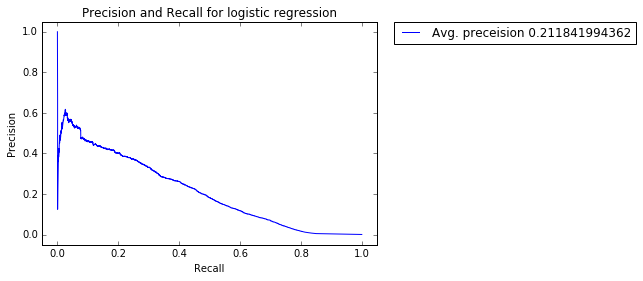

In [301]:
log_model = LogisticRegression(C=10000, penalty='l1')
log_model.fit(X_train, y_train)
preds = log_model.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and Recall for logistic regression')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [155]:
print classification_report(y_test, log_model.predict(X_test))

             precision    recall  f1-score   support

      False       1.00      0.98      0.99   3511712
       True       0.03      0.83      0.06      3218

avg / total       1.00      0.98      0.99   3514930



In [156]:
for name, coef in zip(X_train.columns.values, log_model.coef_[0]):
    print '{}: {}'.format(name, coef)

shortest_path: -3.28071765314e-06
triadic_closeness: 0.523519512229
common_neighbors: -6.91525239262
time_difference: -0.000184663323347
common_referrers: 0.900488515432
src_degree: 0.020855872363
trg_degree: 0.0280838753315
preferential_attachment: 0.00307733379662
adamic_adar: -35.6331272821
leicht_holme_newman: 28.4174671164
resource_allocation: -51.3757820536


### Decision trees
A decision tree is a rule based classifier which can be seen as determining the class of a sample by asking questions to the features such as, *"If there are more than 4 common neighbors, classify it is as a link"* and combining these rules to divide the feature space into regions of different classes. Normally these rules are created by a top-down algorithm which greedily splits the training data based on what split gives the largest decrease in RSS after which the same procedure is recursively applied to the two new partitions, ad nauseam until some stopping criterion is reached.

This leads to a set of rules that will be very good at predicting the training set, however it has a high likelihood of overfitting so usually this larger tree is pruned down in a manner similar to regularization in general linear models which reduces variance at the cost of some bias in the model.

In [145]:
%%time
from sklearn.feature_selection import RFECV
clf = RandomForestClassifier()
rfe_forest = RFECV(estimator=clf, step=1, scoring=make_scorer(scorer, needs_proba=True))
rfe_forest.fit(X_train, y_train)

Wall time: 16min 40s


In [146]:
print "Included and excluded features"
for name, state in zip(X_train.columns.values, rfe_forest.support_):
    print '{}: {}'.format(name, state)

Included and excluded features
shortest_path: True
triadic_closeness: True
common_neighbors: True
time_difference: True
common_referrers: True
src_degree: True
trg_degree: True
preferential_attachment: True
adamic_adar: True
leicht_holme_newman: True
resource_allocation: True


In [147]:
print classification_report(y_test, rfe_forest.predict(X_test))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   3511712
       True       0.50      0.14      0.22      3218

avg / total       1.00      1.00      1.00   3514930



In [148]:
in_out = ['Excluded', 'Included']
for name, in_model in sorted(zip(X_train.columns.values, rfe_forest.get_support()), key=lambda tup: tup[1], reverse=True):
    print name + ": {}".format(in_out[in_model])

shortest_path: Included
triadic_closeness: Included
common_neighbors: Included
time_difference: Included
common_referrers: Included
src_degree: Included
trg_degree: Included
preferential_attachment: Included
adamic_adar: Included
leicht_holme_newman: Included
resource_allocation: Included


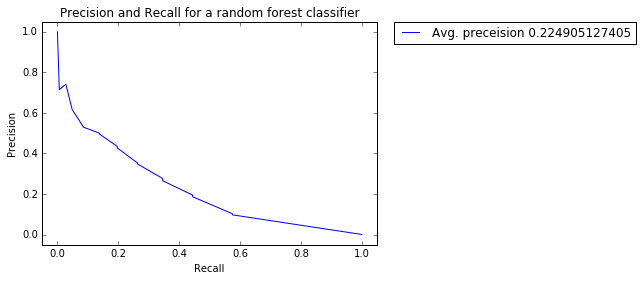

In [149]:
preds = rfe_forest.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and Recall for a random forest classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

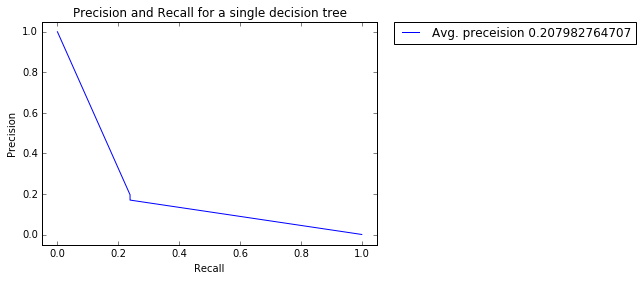


Included and excluded features:
shortest_path: Included
triadic_closeness: Included
common_neighbors: Excluded
time_difference: Included
common_referrers: Included
src_degree: Included
trg_degree: Included
preferential_attachment: Included
adamic_adar: Included
leicht_holme_newman: Included
resource_allocation: Included

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   3511712
       True       0.20      0.24      0.22      3218

avg / total       1.00      1.00      1.00   3514930

Wall time: 4min 43s


In [150]:
%%time
rfe_tree = RFECV(estimator=tree.DecisionTreeClassifier(), step=1, scoring=make_scorer(scorer, needs_proba=True))
rfe_tree.fit(X_train, y_train)
preds = rfe_tree.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])
plt.plot(recall, precision, lw=1, label='Avg. preceision {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and Recall for a single decision tree')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
print
print "Included and excluded features:"
in_out = ['Excluded', 'Included']
for name, in_model in zip(X_train.columns.values, rfe_tree.get_support()):
    print name + ": {}".format(in_out[in_model])
print
print classification_report(y_test, rfe_tree.predict(X_test))

In [151]:
# Export the tree
dot_data = StringIO()
tree.export_graphviz(rfe_tree.estimator_, out_file=dot_data,  
                         feature_names=X_train.columns.values[rfe_tree.support_],  
                         class_names=['No link', 'Link'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("rfe_tree.pdf")

True

In [157]:
random_forest = RandomForestClassifier(n_estimators=20, class_weight='balanced')
random_forest.fit(X_train, y_train)
preds = random_forest.predict_proba(X_test)
mean_avg_precision = average_precision_score(y_test, preds[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, preds[:,1])

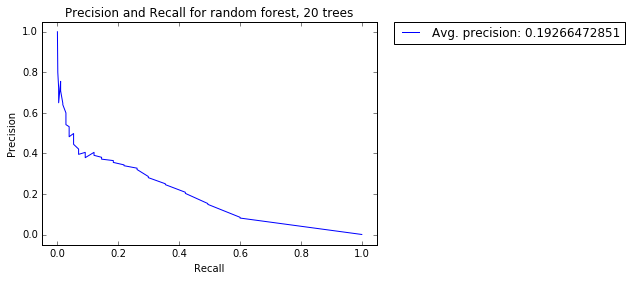

In [158]:
plt.plot(recall, precision, lw=1, label='Avg. precision: {}'.format(mean_avg_precision))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and Recall for random forest, 20 trees')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [160]:
print classification_report(y_test, random_forest.predict(X_test))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00   3511712
       True       0.38      0.09      0.15      3218

avg / total       1.00      1.00      1.00   3514930



### Comparison with unsupervised methods


In [129]:
%run load_data.py
GRAPH = 'EUCHR'
np.random.seed(42)
random.seed(42)


# Find the greatest connected component and work on that
components = []
lengths = []
# Find the greatest component from the undirected version of the graph
for component in nx.connected_component_subgraphs(nx.Graph(G)):
    components.append(component)
    lengths.append(len(component))
# Find the GCC as the largest component and then recreate the directed graph
GCC = components[lengths.index(max(lengths))]
GCC = G.subgraph(GCC.nodes())

In [305]:
test_year = 2013
degrees = [5, 10, 15, 20]
models = [(rfe_tree, 'single_tree'), (random_forest, 'random_forest'), (log_model, 'logistic_regression')]
model_results = {}
for model, name in models:
    model_results[name] = {}
    for degree in degrees:
        res = {}
        nodes = set(x for x,_ in test_data.loc[test_data['src_degree'] == degree, 'source'].index)
        # assert len(nodes) == len([n for n, d in  slice_graph_by_year(test_year, test_year, GCC) if len(GCC[n]) == degree])
        for node in nodes:
            res[node] = {}
            # If there already exists predictions for this node at this degree, load them
            if isfile('pickles/{}_{}_{}.pkl'.format(name, node, degree)):
                res[node] = pkl.load(open('pickles/{}_{}_{}.pkl'.format(name, node, degree), 'rb'))
            else:
                # If the features of the node at this degree has been created, load them
                if isfile('pickles/{}_validation_deg_{}.pkl'.format(node, degree)):
                    panel = pd.read_pickle('pickles/{}_validation_deg_{}.pkl'.format(node, degree))
                # Generate features
                else:
                    dict_to_df = {}
                    e = GCC.edges(node, data=True)
                    if not len(e) == degree:
                        raise Exception("Mismatch: {}".format(len(e)))
                    GCC.remove_edges_from(e[1:degree-1])
                    for i in range(1, degree):
                        to_be_scored = [(node, y, {}) for y in set(GCC.nodes()) - set(node) 
                                        if not (node, y) in set((s,t) for s,t,_ in e[0:i])]
                        data = get_features(GCC, to_be_scored, node+'_{}_edges'.format(i), False)
                        nans = data.isnull().any(1).nonzero()[0]
                        if len(nans)>0:
                            print "Nans in get features: {}".format(nans)
                        dict_to_df[i] = data
                        GCC.add_edge(e[i][0], e[i][1])
                    panel = pd.Panel(dict_to_df)
                    panel.to_pickle('pickles/{}_validation_deg_{}.pkl'.format(node, degree))
                # Perform predictions on generated or loaded features
                for i, df in panel.iteritems():
                    df.dropna()
                    X = df.ix[:, [col for col in data.columns if col not in ['edge', 'source', 'target']]]
                    probs = zip(df['edge'], [p[1] for p in model.predict_proba(X)])
                    probs = sorted(probs, key=lambda x: x[1], reverse=True)
                    res[node][i] = probs[0:degree - i]
                with open('pickles/{}_{}_{}.pkl'.format(name, node, degree), 'wb') as fl:
                    pkl.dump(res[node], fl)
            print "Node done: {}".format(node)
        model_results[name][degree]= res
        print "Degree done: {}".format(degree)
    print "Model done: " + name

Node done: 62012CJ0009
Node done: 62012CJ0353
Node done: 62011CJ0360
Node done: 62011CJ0576
Node done: 62012CJ0321
Node done: 62011CJ0575
Node done: 62011CJ0246
Node done: 62012CJ0079
Node done: 62011CJ0533
Node done: 62012CJ0111
Node done: 62012CJ0137
Node done: 62011CJ0425
Node done: 62011CJ0626
Node done: 62011CJ0435
Node done: 62012CJ0281
Node done: 62011CJ0604
Node done: 62011CJ0065
Node done: 62012CJ0523
Node done: 62011CJ0595
Node done: 62012CJ0274
Node done: 62010CJ0480
Node done: 62012CJ0272
Node done: 62012CJ0010
Node done: 62012CJ0187
Node done: 62011CJ0375
Node done: 62012CJ0279
Node done: 62011CJ0275
Node done: 62012CJ0109
Node done: 62012CJ0225
Node done: 62011CJ0011
Node done: 62011CJ0546
Node done: 62012CJ0095
Node done: 62012CJ0091
Node done: 62012CJ0298
Node done: 62010CJ0627
Node done: 62011CJ0396
Node done: 62011CJ0282
Node done: 62012CJ0062
Node done: 62011CJ0529
Node done: 62011CJ0243
Node done: 62013CJ0168
Degree done: 5
Node done: 62012CJ0001
Node done: 62012CJ0

(array([ 1857.,   528.,   151.,    59.,    15.,    11.,     2.,     2.,
            3.,     3.]),
 array([ 0.        ,  0.31922469,  0.63844938,  0.95767407,  1.27689876,
         1.59612345,  1.91534814,  2.23457283,  2.55379752,  2.87302221,
         3.1922469 ]),
 <a list of 10 Patch objects>)

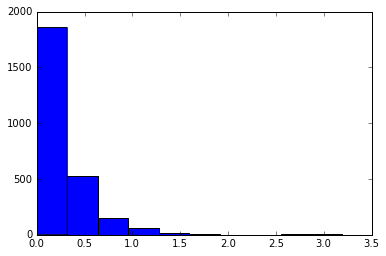

In [339]:
plt.hist(X_train.loc[y_train, 'triadic_closeness'])

(array([  2.99756700e+06,   3.17000000e+02,   2.00000000e+01,
          2.00000000e+00,   1.10000000e+01,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([ 0.        ,  0.61547316,  1.23094632,  1.84641948,  2.46189264,
         3.0773658 ,  3.69283896,  4.30831212,  4.92378528,  5.53925844,
         6.1547316 ]),
 <a list of 10 Patch objects>)

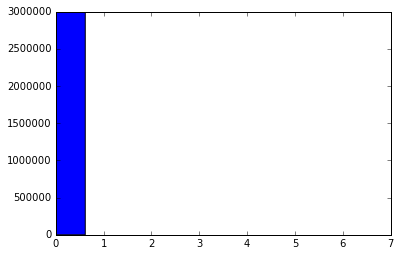

In [338]:
plt.hist(X_train.loc[y_train==False, 'triadic_closeness'])

In [325]:
y_train.values==True

array([False, False, False, ..., False, False, False], dtype=bool)

In [313]:
X = data.ix[:, [col for col in data.columns if col not in ['edge', 'source', 'target']]] 
y = data['edge']

In [317]:
rfe_tree.predict_proba(X)

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [88]:
for i, edge in enumerate(e2[1:]):
    print i

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [63]:
degree

20

In [53]:
sum([1 if y in GCC[node] else 0 for _,y,__ in to_be_scored])

20

In [55]:
sorted(to_be_scored, key=lambda x: x[2]['score'], reverse=True)

[('62009CJ0529', '62009CJ0529', {'score': 0.6687631067426463}),
 ('62009CJ0529', '62005CJ0232', {'score': 0.4021473695386738}),
 ('62009CJ0529', '62005CJ0207', {'score': 0.35214736953867387}),
 ('62009CJ0529', '62009CJ0304', {'score': 0.34676434676434675}),
 ('62009CJ0529', '62009CJ0549', {'score': 0.30311355311355315}),
 ('62009CJ0529', '62003CJ0415', {'score': 0.2570636950432347}),
 ('62009CJ0529', '61993CJ0348', {'score': 0.25331189129143095}),
 ('62009CJ0529', '62006CJ0419', {'score': 0.22373036170990132}),
 ('62009CJ0529', '62009CJ0303', {'score': 0.21978021978021978}),
 ('62009CJ0529', '62009CJ0305', {'score': 0.2039072039072039}),
 ('62009CJ0529', '62000CJ0404', {'score': 0.19824016563146996}),
 ('62009CJ0529', '62006CJ0441', {'score': 0.18563512361466325}),
 ('62009CJ0529', '62005CJ0280', {'score': 0.17243867243867245}),
 ('62009CJ0529', '62009CJ0454', {'score': 0.17226613965744403}),
 ('62009CJ0529', '62007CJ0369', {'score': 0.1598336304218657}),
 ('62009CJ0529', '62002CJ0099'

In [58]:
'62009CJ0529' in GCC['62009CJ0529'].keys()

False

In [60]:
 GCC['62009CJ0529']

{'61998CJ0378': {},
 '61998CJ0480': {},
 '61999CJ0499': {'date': datetime.date(2013, 1, 24)},
 '62008CJ0526': {},
 '62009CJ0331': {},
 '62009CJ0496': {},
 '62010CJ0243': {},
 '62010CJ0354': {},
 '62010CJ0485': {},
 '62010CJ0610': {}}

In [61]:
G['62009CJ0529']

{'61998CJ0378': {'date': datetime.date(2013, 1, 24)},
 '61998CJ0480': {'date': datetime.date(2013, 1, 24)},
 '61999CJ0499': {'date': datetime.date(2013, 1, 24)},
 '62008CJ0526': {'date': datetime.date(2013, 1, 24)},
 '62009CJ0331': {'date': datetime.date(2013, 1, 24)},
 '62009CJ0496': {'date': datetime.date(2013, 1, 24)},
 '62010CJ0243': {'date': datetime.date(2013, 1, 24)},
 '62010CJ0354': {'date': datetime.date(2013, 1, 24)},
 '62010CJ0485': {'date': datetime.date(2013, 1, 24)},
 '62010CJ0610': {'date': datetime.date(2013, 1, 24)}}

In [ ]:
%%time
a = per_node_precision(GCC, model_results['logistic_regression'][10])
b = per_node_precision(GCC, model_results['single_tree'][10])
c = per_node_precision(GCC, model_results['random_forest'][10])
d = {k: sum(p)/len(p) for k,p in a.iteritems() if len(p) != 0}
e = {k: sum(p)/len(p) for k,p in b.iteritems() if len(p) != 0}
f = {k: sum(p)/len(p) for k,p in c.iteritems() if len(p) != 0}
plt.figure(figsize=(20,10))
plt.plot(d.keys(), d.values(), e.keys(), e.values(), f.keys(), f.values(), lw=1.0, marker='o')
plt.legend(['Logistic regression', 'Decision tree', 'Random forest'], markerscale=1, fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Number of edges on source node', fontsize=20)

In [ ]:
srt = sorted(model_results['logistic_regression'][10]['62012CJ0344'], key=lambda x: x[2]['score'], reverse=True)

In [ ]:
y_now = data['edge']
prec = rfe_forest.predict(X)
prob = [p[1] for p in rfe_forest.predict_proba(X)]
z = zip(y_now, prob)

In [ ]:
for ys, pr in zip(y_now, prec):
    if ys == True:
        print ys==pr

In [ ]:
sorted(z, reverse=True)

In [ ]:
print classification_report(y_test, prec)

In [ ]:
ps=[]
for i, edge in enumerate(srt):
    x = edge[0]
    y = edge[1]
    d = edge[2]
    if y in GCC[x]:
        ps.append(d['score'])

In [ ]:
ps

In [ ]:
model_res2 = model_results
for model, degree in model_results.iteritems():

In [ ]:
model_results['logistic_regression']

In [ ]:
def per_node_precision(G, results):
    """
    results : dict
        A dict of {node: [e1, e2, ... e_n]} where e is an edge of the form (source, target, {'n_edges': x, 'score': y}) where
        n_edges number of edges the node had when the prediction was made.
    """
    
    m = 43
    # Create a dict that all the edges sorted by score and grouped by n_edges and then node
    s = {n: {k: [] for k in range(1,m+1)} for n in results.iterkeys()}
    for node, node_res in results.iteritems():
        # Sort the entire list of results
        srt = sorted(node_res, key=lambda x: x[2]['score'], reverse=True)
        for x,y,data in srt:
            # Add each result to its proper bin
            s[node][data['n_edges']].append((x,y,{'score': data['score']}))
    precisions = {k: [] for k in range(1,m+1)}
    edge_set = set(G.edges())
    for node, node_res in s.iteritems():
        n = G.out_degree(node)
        for level, results in node_res.iteritems():
            L = n-level
            if len(results) == 0:
                break
            precisions[level].append(1.0*len([(edge[0],edge[1]) for edge in results[0:L] if (edge[0], edge[1]) in edge_set])/L)
    return precisions

In [ ]:
len(X)

In [ ]:
grps=it.groupby(model_results['logistic_regression'][10], lambda x: x[2])

In [ ]:
list(grps)

In [ ]:
for i,df in enumerate(pn.iteritems()):
    print i

In [ ]:
tt = slice_graph_by_year(2013, 2013, GCC)

In [ ]:
len([n for n, d in tt if len(G[n]) == 15])

In [ ]:
pn

While the accuracy of the logistic model seems incredibly good this simple evaluation hides an important issue which can be seen when looking at the per-class metrics.

In [ ]:

preds = logi.predict(test_data[:,1:])
print classification_report(test_data[:,0], preds)

The model is able to predict the non-existence of links very well, but completely fails to predict existing links which are exactly the cases that are interesting. This can be seen as having a model that will always predict that no link will form will have very nice accuracy due to the imbalance between classes. It is therefore necessary to train the model on an a more balanced dataset.

[Link prediction in dynamic weighted and directed social networks] proposes a way to combat this. Since the set of potential edges, $D$, has the subsets of existing links, $D^+$ and non-existing links, $D^-$, where $D^- >> D^+$ it is possible to split into $m$ sub-sets each of size $|D^+|$, $S_i$ so that $\sum_i S_i = D^-$.

Models are then trained on $D^+ S_i \ \forall \ i \in m$  resulting in $m$ models all trained on the same positive cases. To perform classification of a potential link majority voting among the classifiers is done.

In [ ]:
# Split the cases in positive and negative samples
D_pos = train_data[train_data[:,0] == 1]
D_neg = train_data[train_data[:,0] == 0]

In [ ]:
# Compute models for each case
m = len(D_neg)/len(D_pos)
try:
    models = pkl.load(open('pickles/majority_logistic.pkl', 'rb'))
except:
    models = []
    for i in range(0, m):
        S = np.array(D_neg[i*len(D_pos):(i+1)*len(D_pos)])
        model = LogisticRegression(C=1e5)
        models.append(model.fit(np.append(S[:,1:], D_pos[:,1:], axis=0), np.append(S[:,0], D_pos[:,0], axis = 0)))
    with open('pickles/majority_logistic.pkl', 'wb') as fl:
        pkl.dump(models, fl)

In [ ]:
%%time
# Compute models for each case
m = len(D_neg)/len(D_pos)
try:
    models = pkl.load(open('pickles/majority_svc.pkl', 'rb'))
except:
    models = []
    for i in range(0, m):
        S = np.array(D_neg[i*len(D_pos):(i+1)*len(D_pos)])
        model = LinearSVC()
        models.append(model.fit(np.append(S[:,1:], D_pos[:,1:], axis=0), np.append(S[:,0], D_pos[:,0], axis = 0)))
    with open('pickles/majority_svc.pkl', 'wb') as fl:
        pkl.dump(models, fl)

In [ ]:
%%time
# Create predictions for each model and decide the final outcome by majority voting
try:
    predictions = pkl.load(open('pickles/majority_pred.pkl', 'rb'))
except:
    predictions = np.zeros(test_data.shape[0])
    for i in range(0, len(models)):
        predictions += models[i].predict(test_data[:, 1:])
    with open('pickles/majority_pred.pkl', 'wb') as fl:
        pkl.dump(predictions, fl)

In [ ]:
%%time
# Create predictions for each model and decide the final outcome by majority voting
try:
    svc_pred = pkl.load(open('pickles/majority_svc_pred.pkl', 'rb'))
except:
    svc_pred = np.zeros(test_data.shape[0])
    for i in range(0, len(models)):
        svc_pred += models[i].predict(test_data[:, 1:])
    with open('pickles/majority_svc_pred.pkl', 'wb') as fl:
        pkl.dump(svc_pred, fl)

In [ ]:
voted_result = np.zeros(len(svc_pred))
for i, agg in enumerate(svc_pred):
    if agg > m/2:
        voted_result[i] = 1

In [ ]:
voted_result = np.zeros(len(predictions))
for i, agg in enumerate(predictions):
    if agg > m/2:
        voted_result[i] = 1

In [ ]:
print classification_report(test_data[:,0], voted_result)

In [ ]:
from sklearn import cross_validation as cv

In [ ]:
nodes = slice_graph_by_year(start_date, start_date-7, GCC)

In [ ]:
X_train, X_test, y_train, y_test = cv.train_test_split(train_data[:,1:], train_data[:,0], test_size=0.2)

In [ ]:
2142685L*4

In [ ]:
X_train.shape

In [ ]:
scores = cv.cross_val_score(ll, train_data[:,1:], train_data[:,0], cv=5)

Perform a cross validation experiment on the logistic classifier based on the years 2000 - 2013

In [ ]:
print classification_report(y[test], classifier.predict(X[test]))

In [ ]:
classifier.tree_